# ¿Gana una persona más de 50k dolares al año?

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import confusion_matrix

import joblib

In [2]:
adult = pd.read_excel("data/adult.data.xlsx")

## REVISION DE DATOS

In [3]:
adult.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
adult.shape

(32561, 15)

In [5]:
adult.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
adult.describe()

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
count,32561.000000,3.256100e+04,32561.000000,32561.000000,32561.000000,32561.000000
mean,38.581647,1.897784e+05,10.080679,1077.648844,87.303830,40.437456
std,13.640433,1.055500e+05,2.572720,7385.292085,402.960219,12.347429
min,17.000000,1.228500e+04,1.000000,0.000000,0.000000,1.000000
25%,28.000000,1.178270e+05,9.000000,0.000000,0.000000,40.000000
50%,37.000000,1.783560e+05,10.000000,0.000000,0.000000,40.000000
75%,48.000000,2.370510e+05,12.000000,0.000000,0.000000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.000000,99.000000


In [7]:
adult['income'].value_counts()

income
<=50K    24720
>50K      7841
Name: count, dtype: int64

In [8]:
adult['income'].value_counts(normalize=True)

income
<=50K    0.75919
>50K     0.24081
Name: proportion, dtype: float64

## LIMPIEZA Y TRANSFORMACION

In [9]:
adult.isnull().sum()

age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [10]:
adult.duplicated().sum()

np.int64(24)

In [11]:
adult_clean = adult.drop_duplicates()

In [12]:
adult_clean.shape

(32537, 15)

In [13]:
adult_clean = adult_clean.replace("?", np.nan)

adult_clean.isnull().sum()

age                  0
workclass         1836
fnlwgt               0
education            0
education-num        0
marital-status       0
occupation        1843
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
native-country     582
income               0
dtype: int64

In [14]:
adult_clean = adult_clean.dropna()
adult_clean.shape

(30139, 15)

# EDA

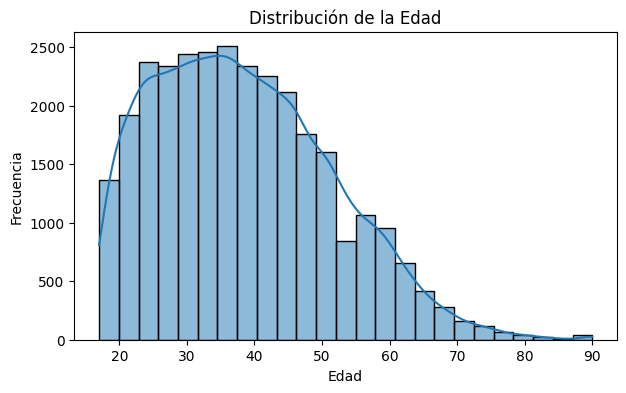

In [15]:
plt.figure(figsize=(7,4))
sns.histplot(adult_clean['age'], bins=25, kde=True)
plt.title("Distribución de la Edad")
plt.xlabel("Edad")
plt.ylabel("Frecuencia")
plt.show()


La mayoría de las personas tienen entre **20 y 45 años**, con una caída gradual a partir de los 50. Esto es relevante porque el ingreso tiende a aumentar con la edad hasta un punto, y luego estabilizarse o bajar.


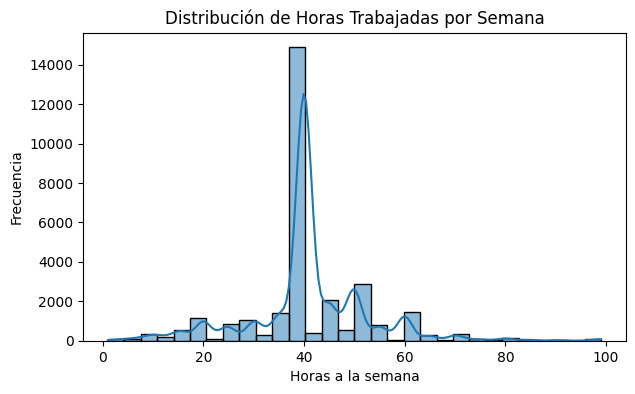

In [16]:
plt.figure(figsize=(7,4))
sns.histplot(adult_clean['hours-per-week'], bins=30, kde=True)
plt.title("Distribución de Horas Trabajadas por Semana")
plt.xlabel("Horas a la semana")
plt.ylabel("Frecuencia")
plt.show()

La mayoría trabaja **entre 35 y 45 horas por semana**, lo que indica jornadas estándar. Existen valores extremos (como 70+ horas) que podrían influir fuertemente en los ingresos.

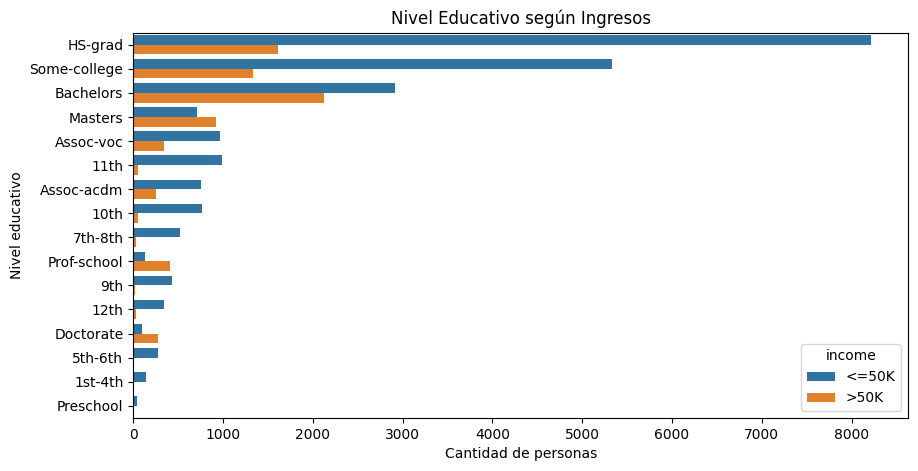

In [17]:
plt.figure(figsize=(10,5))
sns.countplot(y='education', hue='income', data=adult_clean, order=adult_clean['education'].value_counts().index)
plt.title("Nivel Educativo según Ingresos")
plt.xlabel("Cantidad de personas")
plt.ylabel("Nivel educativo")
plt.show()

Los niveles educativos más altos (por ejemplo, *Bachelors, Masters, Doctorate*) tienen mucha mayor proporción de personas con ingresos >50K (1).  
Esto confirma que la **educación es un predictor clave**.

## PREPARACION DE DATOS

In [18]:
adult_clean['income'] = adult_clean['income'].map({'<=50K': 0, '>50K': 1}) #Cambiamos el valor de la columna target a binario.

In [19]:
numeric_cols = adult_clean.select_dtypes(include=['int64', 'float64']).columns.tolist() #Seleccionamos columnas nomuericas.
numeric_cols.remove('income') #Eliminamos columna target.

categorical_cols = adult_clean.select_dtypes(include=['object']).columns.tolist() #Seleccionamos columnas categoricas.

In [20]:
adult_encoded = pd.get_dummies(adult_clean, columns= categorical_cols, drop_first=True) # Convertimos cariables categoricas en numericas.

In [21]:
features = adult_encoded.drop('income', axis=1)
target = adult_encoded['income']

## Train Test Split

In [22]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42, stratify= target)

In [23]:
# Standarizamos valores.

scaler = StandardScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])

## MODELOS

### LOGISTIC REGRESSION

In [24]:
lr = LogisticRegression(max_iter=500)
lr.fit(X_train, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,None
,random_state,None
,solver,'lbfgs'
,max_iter,500
,multi_class,'deprecated'


In [25]:
pred_lr = lr.predict(X_test)

In [26]:
class_report_lr = classification_report(y_test, pred_lr)
print("Classification Report:\n", class_report_lr)

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.93      0.90      4527
           1       0.73      0.60      0.66      1501

    accuracy                           0.85      6028
   macro avg       0.80      0.76      0.78      6028
weighted avg       0.84      0.85      0.84      6028



### KNN

In [27]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [28]:
pred_knn = knn.predict(X_test)

In [29]:
class_report_knn = classification_report(y_test, pred_knn)
print("Classification Report:\n", class_report_knn)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.90      0.89      4527
           1       0.66      0.61      0.64      1501

    accuracy                           0.83      6028
   macro avg       0.77      0.76      0.76      6028
weighted avg       0.82      0.83      0.82      6028



### DECISION TREE

In [30]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,None
,random_state,None
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,class_weight,None


In [31]:
pred_dt = dt.predict(X_test)

In [32]:
class_report_dt = classification_report(y_test, pred_dt)
print("Classification Report:\n", class_report_dt)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.87      0.87      4527
           1       0.62      0.63      0.62      1501

    accuracy                           0.81      6028
   macro avg       0.75      0.75      0.75      6028
weighted avg       0.81      0.81      0.81      6028



### RANDOM FOREST

In [33]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [34]:
pred_rf = rf.predict(X_test)

In [35]:
class_report_rf = classification_report(y_test, pred_rf)
print("Classification Report:\n", class_report_rf)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.93      0.90      4527
           1       0.74      0.62      0.68      1501

    accuracy                           0.85      6028
   macro avg       0.81      0.78      0.79      6028
weighted avg       0.85      0.85      0.85      6028



### GRADIENT BOOSTING

In [36]:
gb = GradientBoostingClassifier(random_state=42)
gb.fit(X_train, y_train)

,loss,'log_loss'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [37]:
pred_gb = gb.predict(X_test)

In [38]:
class_report_gb = classification_report(y_test, pred_gb)
print("Classification Report:\n", class_report_gb)

Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.95      0.91      4527
           1       0.79      0.60      0.68      1501

    accuracy                           0.86      6028
   macro avg       0.83      0.77      0.80      6028
weighted avg       0.85      0.86      0.85      6028



### ADA BOOSTING

In [39]:
ab = AdaBoostClassifier(random_state=42)
ab.fit(X_train, y_train)

,estimator,None
,n_estimators,50
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,42


In [40]:
pred_ab = ab.predict(X_test)

In [41]:
class_report_ab = classification_report(y_test, pred_ab)
print("Classification Report:\n", class_report_ab)

Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.94      0.90      4527
           1       0.75      0.58      0.66      1501

    accuracy                           0.85      6028
   macro avg       0.81      0.76      0.78      6028
weighted avg       0.84      0.85      0.84      6028



## DISTRIBUCIÓN DEL TARGET

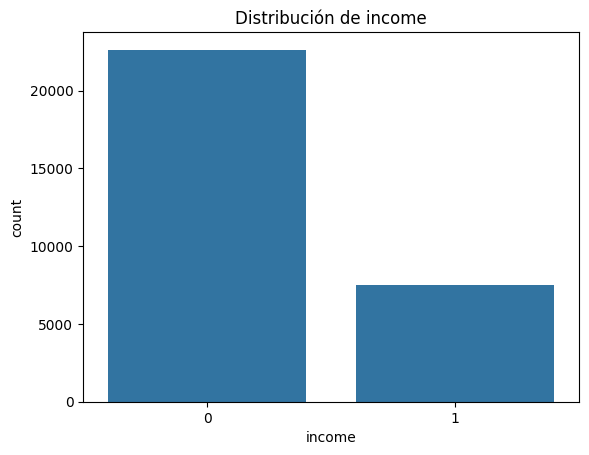

In [42]:
sns.countplot(x='income', data=adult_clean)
plt.title('Distribución de income')
plt.show()

## Problema de Desbalanceo en el Target

La variable objetivo (income) está desbalanceada:

- Aproximadamente **76%** de los casos pertenecen a <=50K (0)
- Solo **24%** pertenecen a >50K (1)

Este desbalanceo provoca que los modelos tiendan a predecir mayoritariamente la clase mayoritaria, obteniendo alta precisión pero muy **bajo recall** en la clase >50K.

### Uso de SMOTE

Para corregir esto, aplicamos **SMOTE**.

In [43]:
smote = SMOTE(random_state=42)

X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

### LOGISTIC REGRESSION + SMOTE

In [44]:
lr_sm = LogisticRegression(max_iter=500)

lr_sm.fit(X_train_res, y_train_res)

pred_lr_sm = lr_sm.predict(X_test)

print("Classification Report (LogReg + SMOTE):")
print(classification_report(y_test, pred_lr_sm))


Classification Report (LogReg + SMOTE):
              precision    recall  f1-score   support

           0       0.92      0.82      0.87      4527
           1       0.60      0.79      0.68      1501

    accuracy                           0.82      6028
   macro avg       0.76      0.81      0.78      6028
weighted avg       0.84      0.82      0.82      6028



### RANDOM FOREST + SMOTE

In [45]:
rf_sm = RandomForestClassifier(random_state=42)

rf_sm.fit(X_train_res, y_train_res)

pred_rf_sm = rf_sm.predict(X_test)

print("Classification Report (RandomForest + SMOTE):")
print(classification_report(y_test, pred_rf_sm))


Classification Report (RandomForest + SMOTE):
              precision    recall  f1-score   support

           0       0.90      0.89      0.90      4527
           1       0.68      0.71      0.70      1501

    accuracy                           0.85      6028
   macro avg       0.79      0.80      0.80      6028
weighted avg       0.85      0.85      0.85      6028



### GRADIENT BOOSTING + SMOTE

In [46]:
gb_sm = GradientBoostingClassifier(random_state=42)

gb_sm.fit(X_train_res, y_train_res)

pred_gb_sm = gb_sm.predict(X_test)

print("Classification Report (GradientBoosting + SMOTE):")
print(classification_report(y_test, pred_gb_sm))


Classification Report (GradientBoosting + SMOTE):
              precision    recall  f1-score   support

           0       0.93      0.83      0.88      4527
           1       0.61      0.81      0.70      1501

    accuracy                           0.83      6028
   macro avg       0.77      0.82      0.79      6028
weighted avg       0.85      0.83      0.83      6028



### Después de aplicar SMOTE:

- El **recall** de la clase >50K mejora significativamente
- El modelo deja de predecir siempre la clase mayoritaria  
- La **F1-score** de la clase positiva aumenta  
- Modelos como **Gradient Boosting** o **Random Forest** se benefician especialmente del rebalanceo

Esto nos permite construir modelos más justos, útiles y equilibrados.

## HYPERPARAMETER TUNING

In [47]:
gb_param_dist = {"n_estimators": [int(x) for x in np.linspace(start=50, stop=300, num=10)], 
                 "learning_rate": np.linspace(0.01, 0.3, 10), 
                 "max_depth": [int(x) for x in np.linspace(2, 10, num=5)], 
                 "subsample": np.linspace(0.7, 1.0, 4)}

gb_model = GradientBoostingClassifier(random_state=42)

gb_random = RandomizedSearchCV(estimator=gb_model, param_distributions=gb_param_dist, n_iter=10, cv=5, n_jobs=-1, random_state=42)

gb_random.fit(X_train_res, y_train_res)

print("Best parameters (GradientBoosting):")
print(gb_random.best_params_)

Best parameters (GradientBoosting):
{'subsample': np.float64(0.9), 'n_estimators': 105, 'max_depth': 8, 'learning_rate': np.float64(0.1711111111111111)}


In [48]:
rf_param_dist = {"n_estimators": [int(x) for x in np.linspace(start=200, stop=1000, num=10)], 
                 "max_depth": [int(x) for x in np.linspace(5, 50, num=10)], 
                 "min_samples_split": [2, 5, 10], 
                 "min_samples_leaf": [1, 2, 4]}

rf_model = RandomForestClassifier(random_state=42)

rf_random = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_dist, n_iter=10, cv=5, n_jobs=-1, random_state=42)

rf_random.fit(X_train_res, y_train_res)

print("Best parameters (RandomForest):")
print(rf_random.best_params_)

Best parameters (RandomForest):
{'n_estimators': 288, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_depth': 45}


In [49]:
best_gb = gb_random.best_estimator_

pred_gb_tuned = best_gb.predict(X_test)

print(classification_report(y_test, pred_gb_tuned))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90      4527
           1       0.70      0.70      0.70      1501

    accuracy                           0.85      6028
   macro avg       0.80      0.80      0.80      6028
weighted avg       0.85      0.85      0.85      6028



In [50]:
best_rf = rf_random.best_estimator_

pred_rf_tuned = best_rf.predict(X_test)

print(classification_report(y_test, pred_rf_tuned))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      4527
           1       0.67      0.74      0.70      1501

    accuracy                           0.85      6028
   macro avg       0.79      0.81      0.80      6028
weighted avg       0.85      0.85      0.85      6028



In [51]:
# Predicciones del mejor modelo sobre los datos de test
y_pred_best = best_gb.predict(X_test)


Guardada matriz_confusion.png


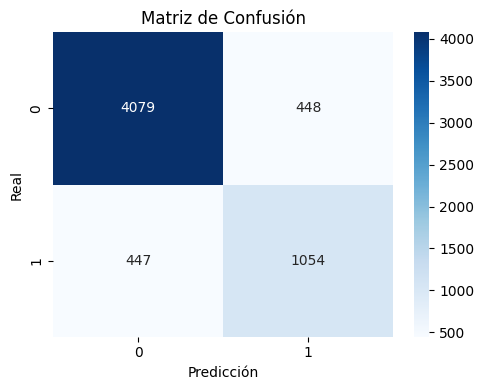

In [52]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred_best)

fig_cm, ax = plt.subplots(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
ax.set_xlabel("Predicción")
ax.set_ylabel("Real")
ax.set_title("Matriz de Confusión")
plt.tight_layout()

fig_cm.savefig("images/matriz_confusion.png", dpi=300)
print("Guardada matriz_confusion.png")


Guardada importancia_variables.png


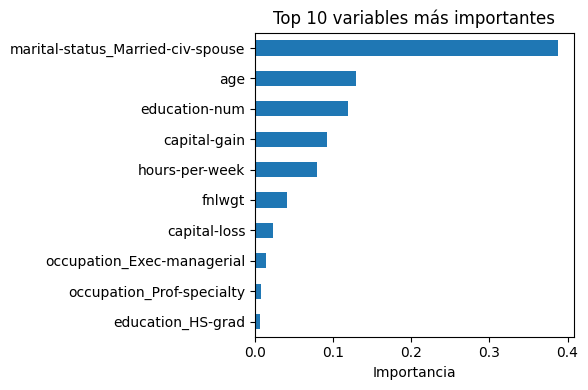

In [53]:
feature_importances = pd.Series(best_gb.feature_importances_, index=features.columns)
top_features = feature_importances.sort_values(ascending=False).head(10)

fig_imp, ax = plt.subplots(figsize=(6,4))
top_features[::-1].plot(kind='barh', ax=ax)
ax.set_title("Top 10 variables más importantes")
ax.set_xlabel("Importancia")
plt.tight_layout()

fig_imp.savefig("images/importancia_variables.png", dpi=300)
print("Guardada importancia_variables.png")


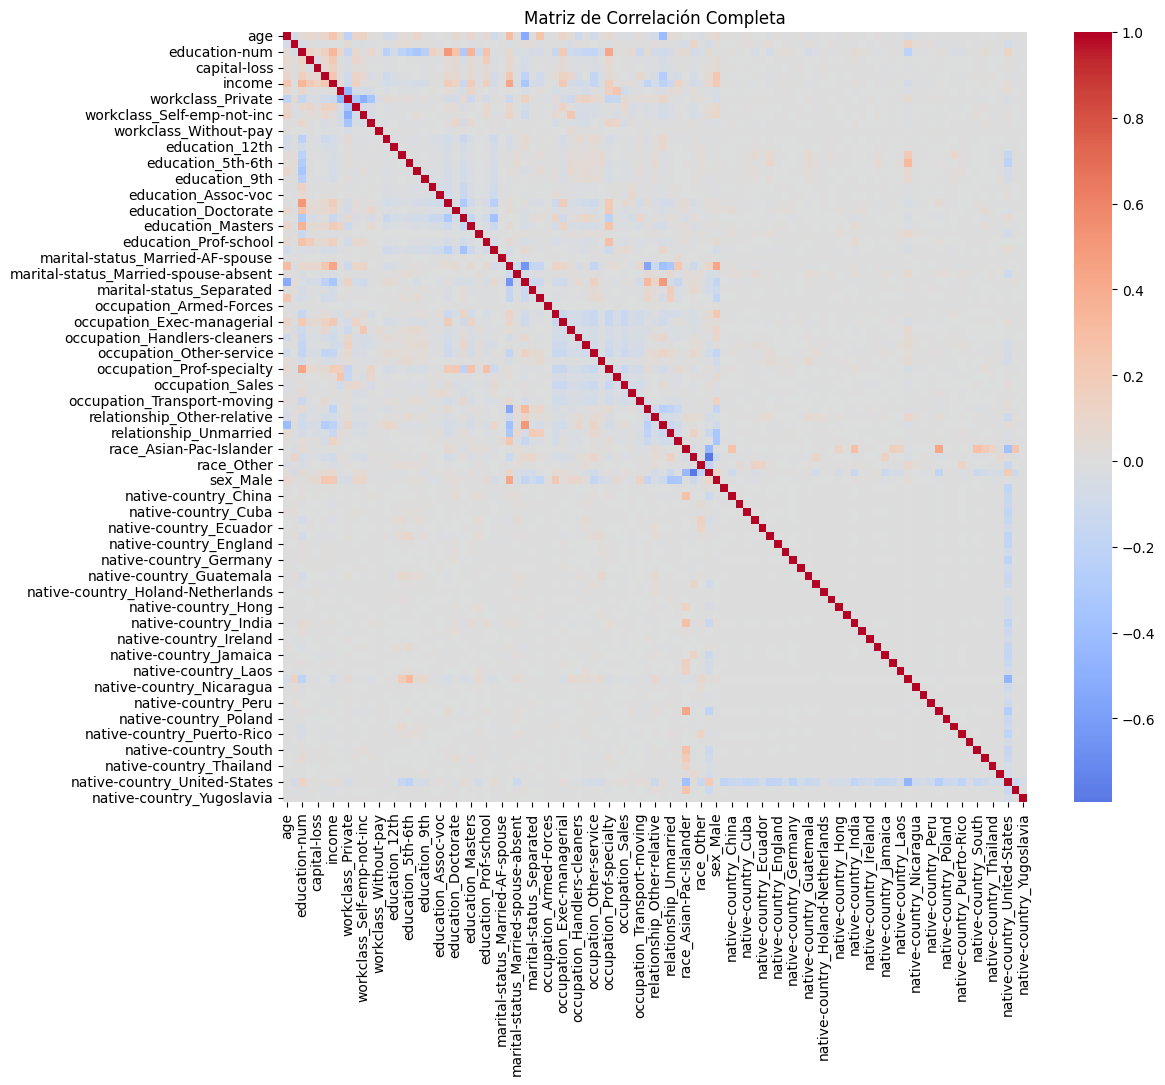

In [54]:
plt.figure(figsize=(12,10))
sns.heatmap(adult_encoded.corr(), cmap="coolwarm", center=0)
plt.title("Matriz de Correlación Completa")
plt.show()

In [55]:
corr_with_income = adult_encoded.corr()["income"].sort_values(ascending=False)
corr_with_income


income                               1.000000
marital-status_Married-civ-spouse    0.445329
education-num                        0.335413
age                                  0.242017
hours-per-week                       0.229435
                                       ...   
relationship_Unmarried              -0.145894
occupation_Other-service            -0.165958
relationship_Not-in-family          -0.193066
relationship_Own-child              -0.226237
marital-status_Never-married        -0.319894
Name: income, Length: 97, dtype: float64

In [56]:
adult_clean['native-country'].value_counts()

native-country
United-States                 27487
Mexico                          606
Philippines                     188
Germany                         128
Puerto-Rico                     109
Canada                          107
El-Salvador                     100
India                           100
Cuba                             92
England                          86
Jamaica                          80
South                            71
Italy                            68
China                            68
Dominican-Republic               67
Vietnam                          64
Guatemala                        61
Japan                            59
Columbia                         56
Poland                           56
Haiti                            42
Iran                             42
Taiwan                           42
Portugal                         34
Nicaragua                        33
Peru                             30
Greece                           29
France       

## Conclusiones Finales

El objetivo del proyecto era predecir si una persona gana más de 50.000 dólares al año a partir de sus características demográficas y laborales. Tras un proceso completo de análisis, limpieza, preparación y modelado, podemos extraer las siguientes conclusiones:

### 1. El dataset requiere una limpieza cuidadosa  
El conjunto Adult Census Income contiene valores faltantes representados como `"?"`, duplicados y múltiples variables categóricas. Tras la limpieza y codificación, los datos quedaron listos para el modelado sin pérdida significativa de información.

### 2. Las variables muestran patrones coherentes  
El análisis exploratorio reveló relaciones claras:
- Los ingresos altos se asocian con mayor nivel educativo.  
- Las personas que trabajan más horas por semana tienden a ganar más.  
- La edad muestra un patrón creciente hasta cierto punto. 

Estos patrones coinciden con tendencias del mercado laboral real.

### 3. La variable objetivo está desbalanceada  
Solo el 24% de los registros corresponden a ingresos >50K.  
Sin tratar este desbalance, los modelos favorecen fuertemente la clase mayoritaria.  
La aplicación de **SMOTE** en el conjunto de entrenamiento equilibró el dataset y mejoró especialmente el **recall** y el **F1-score** de la clase >50K.

### 4. Varios modelos fueron evaluados  
Probamos modelos lineales, basados en árboles, vecinos y métodos en ensamblado (ensembles).  
El rendimiento mejoró notablemente al usar algoritmos más robustos como **Random Forest** y, especialmente, **Gradient Boosting**.

### 5. El mejor modelo fue Gradient Boosting  
Tras la optimización mediante *RandomizedSearchCV*, Gradient Boosting ofreció:
- Buen equilibrio entre precisión, recall y F1   
- Buena estabilidad bajo datos rebalanceados

Además, este modelo permite interpretar la importancia de las variables, destacando:
- `capital-gain`
- `education-num`
- `age`
- `hours-per-week`

Todas ellas tienen sentido dentro del contexto socioeconómico del dataset.

### 6. Consideraciones éticas  
El dataset contiene variables sensibles como **sexo** y **raza**, lo cual puede introducir o amplificar sesgos en el modelo.  
En aplicaciones reales, sería crítico evaluar la equidad del algoritmo, o incluso restringir el uso de estas variables para evitar decisiones discriminatorias.

---

### Conclusión general  
El proyecto demuestra que es posible construir un modelo predictivo sólido para estimar si una persona ganará más de 50K dólares al año.  
Mediante una buena preparación de datos, técnicas de rebalanceo y modelos avanzados, se obtiene un rendimiento competitivo y resultados interpretables.  
Aun así, dado el contenido sensible del dataset, cualquier aplicación real debe incorporar análisis éticos y controles de sesgo.

In [57]:
joblib.dump(best_gb, "models/best_model.pkl")

['models/best_model.pkl']

In [58]:
columnas_modelo = features.columns.tolist()
joblib.dump(columnas_modelo, "models/columnas_modelo.pkl")

['models/columnas_modelo.pkl']

## Consideraciones Éticas y Posibles Sesgos del Modelo

El dataset utilizado incluye variables sensibles como **sexo** y **raza**. Aunque estas características existen en los datos reales, pueden introducir **sesgos históricos** en el modelo.

Por ejemplo:
- Los hombres aparecen con mayor proporción de ingresos >50K  
- Algunas razas están subrepresentadas o sobrerrepresentadas  

El modelo puede aprender estos patrones y **reforzar inequidades sociales** si se usa en procesos reales de selección, préstamos o ayudas.

### Reflexión

Este proyecto incluye estas variables para efectos didácticos y de análisis, pero en un contexto profesional se debe:

- Evaluar las métricas por grupos 
- Considerar eliminar o anonimizar variables sensibles  
- Garantizar que las decisiones automatizadas no discriminen  

La ética es una parte fundamental del machine learning moderno, especialmente cuando los modelos afectan a personas reales.